# Using PyDAP for simple remote data access using DAP4

This notebook contains a simple example of how to use PyDAP and DAP4 to pull
data from remote DAP4 servers into your Python program's memory space
so that the data may be analyized and displayed.

We show how to use simple HTTP requests to look at a dataset's metadata 
and how to use the PyDAP package to read data into numpy arrays and plot 
(or do other things) with those data. PyDAP provides lazy evaluation, so 
data are read only when needed.

This tutorial utilizes the NASA Global High Resolution Sea Surface Temperature from the GOES-16 satellite. You may wish to review the summary on our [Tutorial Datasets page](https://opendap.github.io/documentation/tutorials/TutorialDatasets.html#_nasa_global_high_resolution_sea_surface_temperature_goes_16_satellite) before continuing.

<!-- You can run this tutorial in your browser by [launching it in binder](https://mybinder.org/v2/gh/OPENDAP/notebooks/master?labpath=tutorials%2Fpydap_dap4_basic.ipynb) [<img style="padding-top: 3px" src="https://mybinder.org/badge_logo.svg"/>](https://mybinder.org/v2/gh/OPENDAP/notebooks/master?labpath=tutorials%2Fpydap_dap4_basic.ipynb) -->


Copyright (C) 2023 OPeNDAP, Inc.
This Jupyter Notebook is made available under the [Creative Commons Attribution license 4.0](https://creativecommons.org/licenses/by/4.0/).

In [38]:
# The requests package provides a high-level interface to HTTP/S
# Install using 'conda install requests'
import requests

# PyDAP is an alternative to using the NetCDF library to read data.
from pydap.client import open_url
from pydap.cas.urs import setup_session


# Use matplotlib and numpy for plotting and local data manipulation
import matplotlib.pyplot as plt
import numpy as np

# Basemap is an alternative to Cartopy
from mpl_toolkits.basemap import Basemap

# Teh Code package makes for a nice display of information
from IPython.display import Code

import sys
# Allow us to print the big things...
# np.set_printoptions(threshold=sys.maxsize)  


#import thread_safe_sessions
#my_session = thread_safe_sessions.get_session()
#
# Importing the star of our show, PyDAP!
# import pydap

## dataset_url

The dataset_url is the DAP2/DAP4 service endpoint for the dataset.

The original publisher of this data is NASA, and NASA requires that all users
authenticate in order to access data. Setting up authentication takes additional
steps. If you don't wish to configure the authentication, this tutorial may
also be used with a copy of the data hosted on test.opendap.org, without a
requirement of authenticated access.

In order to use the authenticated access to NASA's data:
1. [Configure your client (in this case PyDAP) to authenticate with the appropriate Earthdata Login (EDL) service](https://opendap.github.io/documentation/tutorials/ClientAuthentication.html#_pydap)
1. Set `USE_ORIGINAL_SERVICE=True` in the following code block, before you run it.


In [39]:
USE_ORIGINAL_SERVICE=True

if(USE_ORIGINAL_SERVICE):
    dataset_url = "dap4://opendap.earthdata.nasa.gov/collections/C2036877806-POCLOUD/granules/20220812010000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20220812_010000-v02.0-fv01.0"
else:
    dataset_url = "dap4://test.opendap.org/opendap/tutorials/20220812010000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20220812_010000-v02.0-fv01.0.nc"

print ("dataset_url: ", dataset_url)


dataset_url:  dap4://opendap.earthdata.nasa.gov/collections/C2036877806-POCLOUD/granules/20220812010000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20220812_010000-v02.0-fv01.0


PyDAP, like the NetCDF libraries, uses a protocol convention so that it
may easily distinguish between DAP2 protocol URLs (_http://_ & _https://_) and
DAP4 protocol URLs (_dap4://_) This means that in order for the DAP4 URL that
PyDAP is expecting we need to replace the current http(s) protocol with the DAP4
protocol.

In [40]:
if dataset_url.find("https") == 0 :
    dap4_url=dataset_url.replace("https://","dap4://",1)
else :
    dap4_url=dataset_url.replace("http://","dap4://",1)

print ("dap4_url: ", dap4_url)


dap4_url:  dap4://opendap.earthdata.nasa.gov/collections/C2036877806-POCLOUD/granules/20220812010000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20220812_010000-v02.0-fv01.0


### Opening the dataset URL to build a dataset
In PyDAP, we use the PyDAP Client to open a remote dataset and retrun it's
associated Dataset object. When we call ```pydap.client.open_url()```, the client
downloads the DMR (the dap4 metadata response), parses it, and then builds a
PyDAP dataset object from it. In the process interpreting the:
- data types including endianess
- shapes
- hierarchy (groups)
- relations (maps) of variables and dimensions
- variable attributes

No data values are downloaded at this point; rather, 'DummyData' of the
appropriate type and shape are inserted into the dataset along with the
metadata.

To utilize the DAP4 protocol one of two things maybe done. Either:
- Use the DAP4 protocol scheme, 'dap4://', in the url (canonical)
- Specifing the 'protocol scheme' kwarg in the function call:
  ```pydap.client.open_url(url, protocol='dap4', **kwargs)```.



In [42]:
# You can use either one of these... The first version will force the use of the DAP4 protocol.
# The second will use DAP2 if the URL starts with 'http...' and DAP if it starts with 'dap4...'

# pydap_ds = pydap.client.open_url(dataset_url, protocol="dap4")

pydap_ds = pydap.client.open_url(dap4_url)

pydap_ds._dict


OrderedDict([('wind_speed',
              <BaseType with data Dap4BaseProxy('http://opendap.earthdata.nasa.gov/collections/C2036877806-POCLOUD/granules/20220812010000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20220812_010000-v02.0-fv01.0', 'wind_speed', dtype('int8'), (1, 2400, 2400), (slice(None, None, None), slice(None, None, None), slice(None, None, None)))>),
             ('lon',
              <BaseType with data Dap4BaseProxy('http://opendap.earthdata.nasa.gov/collections/C2036877806-POCLOUD/granules/20220812010000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20220812_010000-v02.0-fv01.0', 'lon', dtype('>f4'), (2400,), (slice(None, None, None),))>),
             ('or_longitude',
              <BaseType with data Dap4BaseProxy('http://opendap.earthdata.nasa.gov/collections/C2036877806-POCLOUD/granules/20220812010000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20220812_010000-v02.0-fv01.0', 'or_longitude', dtype('>i2'), (1, 2400, 2400), (slice(None, None, None), s

## Using PyDAP to read values

In [43]:
print(pydap_ds)

<DatasetType with children 'wind_speed', 'lon', 'or_longitude', 'time', 'sses_standard_deviation', 'sst_dtime', 'solar_zenith_angle', 'sea_ice_fraction', 'l2p_flags', 'sources_of_adi', 'aerosol_dynamic_indicator', 'sea_surface_temperature', 'quality_level', 'dt_analysis', 'satellite_zenith_angle', 'lat', 'adi_dtime_from_sst', 'or_latitude', 'sses_bias'>


In [44]:
print("Domain Coordinates")
print("time", pydap_ds.time.shape)
print("lat", pydap_ds.lat.shape)
print("lon", pydap_ds.lon.shape,"\n")

print("Range Variables")
print("sea_surface_temperature", pydap_ds.sea_surface_temperature.shape)
print("wind_speed", pydap_ds.wind_speed.shape)


Domain Coordinates
time (1,)
lat (2400,)
lon (2400,) 

Range Variables
sea_surface_temperature (1, 2400, 2400)
wind_speed (1, 2400, 2400)


### PyDAP only reads the data when  needed
The above calls to determine the variables shapes, just like the **open_url()**
call, do not retrieve data values. When the code *accesses* data
values in the cells below the data transferred.

This assignment:
```
    time = pydap_ds.time.data[:]
```
causes data values to be readread. Note that only time data are being retrieved
in this statement.

In [45]:
# Get and inspect the domain coordinate variable "time"
time = pydap_ds.time.data[:]
print("time",time.shape,time,"\n")

time (1,) [1313110800] 



In [46]:
# Get and inspect the domain coordinate variable "lat"
lat = pydap_ds.lat.data[:]
print("lat",lat.shape,": ",lat,"\n")

lat (2400,) :  [-59.975 -59.925 -59.875 ...  59.875  59.925  59.975] 



In [47]:
# Get and inspect the domain coordinate variable "lon"
lon = pydap_ds.lon.data[:]
print("lon", lon.shape, "\n")
print( lon, "\n")

lon (2400,) 

[-134.975 -134.925 -134.875 ...  -15.125  -15.075  -15.025] 



In [48]:
# Get and inspect the range coordinate variable "sea_surface_temperature"
sst=pydap_ds.sea_surface_temperature.data[:]
print(sst)

[[[-32768 -32768 -32768 ... -32768 -32768 -32768]
  [-32768 -32768 -32768 ... -32768 -32768 -32768]
  [-32768 -32768 -32768 ... -32768 -32768 -32768]
  ...
  [-32768 -32768 -32768 ... -32768 -32768 -32768]
  [-32768 -32768 -32768 ...   1513   1513   1513]
  [-32768 -32768 -32768 ...   1345   1345 -32768]]]


In [49]:
#
# Here we drop the time dimension
# (which is now has size 1) using numpy.squeeze()

print("Before Squeeze, sst.shape",sst.shape)
sst = np.squeeze(sst)
print("After Squeeze, sst.shape",sst.shape)

#
# Convert to Float32 so that we can meaningfull fill values for BaseMap
sst = sst[:].astype(np.float32)

# Create FillValues
sst[sst < -32000] = np.nan



Before Squeeze, sst.shape (1, 2400, 2400)
After Squeeze, sst.shape (2400, 2400)


X (2400, 2400)
Y (2400, 2400)
sst (2400, 2400)


Text(0.5, 1.0, 'Sea Surface Temperature')

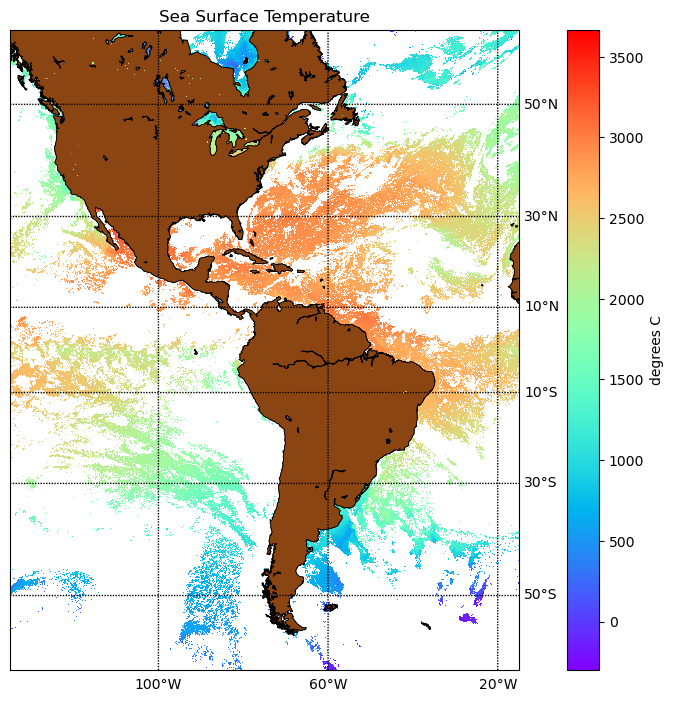

In [50]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# BaseMap
# The resolution can be l (low), i (intermediate), h (high), f (full)
# But you have to install/configure everything but low
#
# These bounds were chosen based on the bounds of the data. The bounds
# are documented on the TuorialsDatasets page: 
# https://opendap.github.io/documentation/tutorials/TutorialDatasets.html
#
m = Basemap(
    llcrnrlon=-135.,
    llcrnrlat=-60.,
    urcrnrlon=-15.,
    urcrnrlat=60.,
    resolution='l',
    projection='merc')

m.fillcontinents(color='saddlebrown',lake_color='cornflowerblue')

# draw lat and lon line (parallels and meridians).
# and set the axis labels (labels = [left,right,top,bottom])
parallels = np.arange(-70., 80., 20.)
m.drawparallels(parallels, labels=[False,True,False,False])
meridians = np.arange(-180., 180., 40.)
m.drawmeridians(meridians, labels=[False,False,False,True])

# Use meshgrid(lon, lat) to build matrices for the lon, lat values
# and then convert them to map projection coordinates for the Basemap
# object 'm.'

X, Y = m(*np.meshgrid(lon, lat))

print("X",X.shape)
print("Y",Y.shape)
print("sst",sst.shape)

# Plot using the rainbox color map
colors_ = m.pcolormesh(X, Y, sst, cmap=plt.get_cmap('rainbow'))

m.drawcoastlines(linewidth=0.5)

cb = plt.colorbar(colors_)
cb.set_label("degrees C")
m.drawcoastlines(linewidth=0.5)

ax.set_title('Sea Surface Temperature')